In [8]:
from google.colab import drive
import sys
drive.mount("/content/drive")
sys.path.append("/content/drive/My Drive/SH")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.special import fresnel as _fresnel
from scipy.spatial import KDTree
import pandas as pd
from functools import partial
import typing
from ipywidgets import interact
from pathlib import Path

calculator = clothoidlib.ClothoidCalculator()

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")

The clothoid is given by the Fresnel integrals
$$S(u) = \int_0^u{\sin\frac{\pi s^2}{2} \ ds}$$
and
$$C(u) = \int_0^u{\cos\frac{\pi s^2}{2} \ ds}$$
as the parametric equations $x(t)=C(t)$ and $y(t)=S(t)$.

The derivative at a specific point $(x(t), y(t))$ is hence
$$
\frac{dy}{dx} = \frac{\sin\frac{\pi t^2}{2}}{\cos\frac{\pi t^2}{2}} = \tan \frac{\pi t^2}{2},
$$
so the angle $\theta$ given $t$ is
$$
\theta(t) = \arctan \left( \tan \frac{\pi t^2}{2} \right)
= \frac{\pi t^2}{2}.
$$

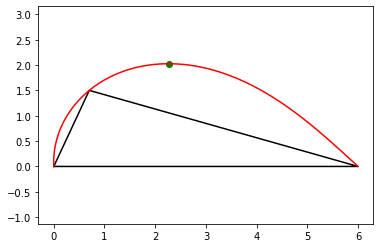

In [11]:
def pad(X):
        return np.hstack([X, np.ones((X.shape[0], 1))])

def unpad(X):
    return X[:,:-1]

def compute_transformation_matrix(I, O):
    A, *_ = np.linalg.lstsq(pad(I), pad(O), rcond=None)
    return A

def affine_transform(I, A):
    return unpad(pad(I) @ A)

def plot_clothoid_given_points(start, intermediate, goal, c="k"):
    (gamma1, gamma2, alpha, beta, t0, t1, t2, lambda_b, lambda_c), subgoal = calculator.lookup_points(start, intermediate, goal)
    plt.axis("equal")
    plt.plot(*list(zip(start, intermediate, goal, start)), c=c)

    c1, c2 = np.stack(clothoidlib.fresnel((t1, t2)), axis=1)
    points = clothoidlib.ChangeOfBasis(c1, c2)(np.stack(clothoidlib.fresnel(np.linspace(0, t2, 200)), axis=1))
    v_b = intermediate - goal
    v_c = start - goal
    points = v_b[:, np.newaxis] * points[..., 0] + v_c[:, np.newaxis] * points[..., 1]
    points += goal[:, np.newaxis]
    plt.plot(*points, c="r")

    plt.scatter(*subgoal, c="g")


start = np.array((0., 0)) # current output
intermediate = np.array((.7, 1.5)) # sample
goal = np.array((6., 0)) # goal/subgoal

plot_clothoid_given_points(start, intermediate, goal)

In [12]:
def save_clothoid_given_points(start, intermediate, goal, filename: str):
    (gamma1, gamma2, alpha, beta, t0, t1, t2, lambda_b, lambda_c), subgoal = calculator.lookup_points(start, intermediate, goal)
    
    c1, c2 = np.stack(clothoidlib.fresnel((t1, t2)), axis=1)
    points = clothoidlib.ChangeOfBasis(c1, c2)(np.stack(clothoidlib.fresnel(np.linspace(0, t2, 200)), axis=1))
    v_b = intermediate - goal
    v_c = start - goal
    points = v_b[:, np.newaxis] * points[..., 0] + v_c[:, np.newaxis] * points[..., 1]
    points += goal[:, np.newaxis]
    
    with open(DATA_DIR / filename, "w") as f:
        for point in points.T:
            f.write("\t".join(map(str, point)) + "\n")
    
    print("File:", filename)
    print("  A:", tuple(goal))
    print("  B:", tuple(intermediate))
    print("  C:", tuple(start))
    print("  Q:", tuple(subgoal))
    print("  t0:", t0)
    print("  t1:", t1)
    print("  t2:", t2)
    print("  gamma1:", gamma1, f"({np.degrees(gamma1)}°)")
    print("  gamma2:", gamma2, f"({np.degrees(gamma2)}°)")
    print("  alpha: ", alpha, f"({np.degrees(alpha)}°)")
    print("  beta:  ", beta, f"({np.degrees(beta)}°)")
    print("  theta: ", alpha+beta, f"({np.degrees(alpha+beta)}°)")

save_clothoid_given_points(start, intermediate, goal, filename="clothoid_segment_with_subgoal.dat")

File: clothoid_segment_with_subgoal.dat
  A: (6.0, 0.0)
  B: (0.7, 1.5)
  C: (0.0, 0.0)
  Q: (2.2688673758889757, 2.0259456611567335)
  t0: 0.6883124830879321
  t1: 0.955315310280732
  t2: 1.2275194912500151
  gamma1: 1.7316175880199154 (99.2143795241645°)
  gamma2: 1.1341691669813554 (64.98310652189998°)
  alpha:  1.6211289253583432 (92.88384546961173°)
  beta:   0.7457534223182132 (42.72852365627091°)
  theta:  2.3668823476765564 (135.61236912588262°)


File: adaptive_clothoid_initial.dat
  A: (6.0, 0.0)
  B: (0.5, 2.0)
  C: (0.0, 0.0)
  Q: (2.4813914274985445, 2.546496383899926)
  t0: 0.683111129311449
  t1: 1.0090626326377243
  t2: 1.3471506281091268
  gamma1: 1.467003986337854 (84.05313694602651°)
  gamma2: 1.3258176636680326 (75.96375653207353°)
  alpha:  1.9814464628334245 (113.52851965148076°)
  beta:   0.8692579820906472 (49.804813681852586°)
  theta:  2.8507044449240717 (163.33333333333334°)
File: adaptive_clothoid_candidate.dat
  A: (6.0, 0.0)
  B: (1.5, 3.0)
  C: (0.0, 0.0)
  Q: (4.610848242768206, 1.7252364499564798)
  t0: 0.32421771873411415
  t1: 0.8339503888294594
  t2: 1.4321060731250175
  gamma1: 1.446441332248135 (82.8749836510982°)
  gamma2: 1.1071487177940904 (63.43494882292201°)
  alpha:  2.2724784693564644 (130.2034253284748°)
  beta:   0.9491113927588481 (54.38007709286544°)
  theta:  3.2215898621153123 (184.58350242134023°)
File: adaptive_clothoid_rival.dat
  A: (6.0, 0.0)
  B: (-0.5, 3.0)
  C: (0.0, 0.0)
  Q: (

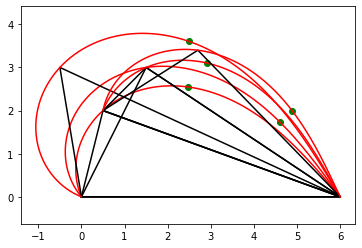

In [13]:
def plot_and_save(start, sample, goal, name: str):
    plot_clothoid_given_points(start, sample, goal)
    save_clothoid_given_points(start, sample, goal, filename=f"adaptive_clothoid_{name}.dat")

start = np.array((0., 0))
sample = np.array((.5, 2))
goal = np.array((6., 0))
plot_and_save(start, sample, goal, "initial")

candidate = sample + [1., 1]
plot_and_save(start, candidate, goal, "candidate")

rival = sample + [-1., 1]
plot_and_save(start, rival, goal, "rival")

start, sample = sample, candidate
plot_and_save(start, sample, goal, "chosen_clothoid")

achieved_subgoal = np.array((2.7, 3.4))
plot_and_save(start, achieved_subgoal, goal, "subgoal_clothoid")

File: adaptive_clothoid_bad_candidate.dat
  A: (6.0, 0.0)
  B: (-0.4, 1.0)
  C: (0.0, 0.0)
  Q: (-0.12231556860699033, 2.044560309044271)
  t0: 1.1200248465360307
  t1: 1.2795330290148461
  t2: 1.4390412114936617
  gamma1: 1.035293207758591 (59.31793136312796°)
  gamma2: 1.9513027039072615 (111.80140948635182°)
  alpha:  2.2977688200723643 (131.6524556869015°)
  beta:   0.9550984301478376 (54.72310906704156°)
  theta:  3.252867250220202 (186.37556475394308°)


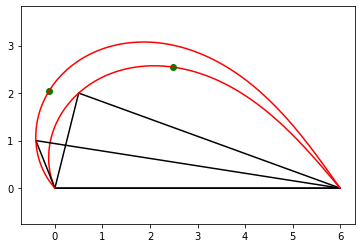

In [19]:
start = np.array((0., 0))
sample = np.array((.5, 2))
goal = np.array((6., 0))
candidate = np.array((-.4, 1))

plot_clothoid_given_points(start, sample, goal)

plot_and_save(start, candidate, goal, "bad_candidate")